In [ ]:
import numpy as np
from sklearn.linear_model import LassoCV, Lasso
from numpy.linalg import norm
import warnings
warnings.filterwarnings("ignore")

# Parameters
n = 100
p = 150
B = 25000
sigma2_true = 1
alpha = 0.05
s_list = [6, 10, 14, 20, 50, 100, 150]

# Storage
results = {s: {'RCV': [], 'AIC': [], 'SURE': []} for s in s_list}

# Generate Gamma (exchangeable structure)
def generate_X(n, p, a=10):
    I = np.eye(p)
    E = np.ones((p, p))
    Gamma = I + a * E
    L = np.linalg.cholesky(Gamma)
    Z = np.random.randn(n, p)
    return Z @ L.T

# Generate beta for given sparsity level
def generate_beta(s, p=150):
    if s == 6:
        beta = np.array([1, -1, 0.5, -0.5, 0.2, 0] + [0]*(p-6))
    elif s == 10:
        beta = np.array([1, -1, 0.8, -0.6, 0.6, -0.4, 0.2, 0] + [0]*(p-8))
    elif s == 14:
        beta = np.array([1, -1, 0.8, -0.7, 0.7, -0.6, 0.6, -0.5, 0.5, -0.4, 0.4, -0.2, 0, 0] + [0]*(p-14))
    elif s == 20:
        beta = np.concatenate([np.linspace(1, 0.1, 20), np.zeros(p - 20)])
    elif s == 50:
        beta = np.concatenate([np.linspace(1, 0.1, 20), np.random.uniform(0, 0.1, 30), np.zeros(p - 50)])
    elif s == 100:
        beta = np.concatenate([np.linspace(1, 0.1, 20), np.random.uniform(0, 0.1, 80), np.zeros(p - 100)])
    elif s == 150:
        beta = np.concatenate([np.linspace(1, 0.1, 20), np.random.uniform(0, 0.1, 130)])
    return beta

# Main simulation loop
for s in s_list:
    beta_true = generate_beta(s, p)
    for b in range(B):
        X = generate_X(n, p)
        eps = np.random.normal(0, np.sqrt(sigma2_true), size=n)
        y = X @ beta_true + eps

        # Lambda grid for tuning
        lasso_cv = LassoCV(cv=5, fit_intercept=False, max_iter=10000).fit(X, y)
        lambda_rcv = lasso_cv.alpha_
        beta_rcv = Lasso(alpha=lambda_rcv, fit_intercept=False, max_iter=10000).fit(X, y).coef_
        res_rcv = y - X @ beta_rcv
        sigma2_rcv = np.mean(res_rcv**2)
        results[s]['RCV'].append(sigma2_rcv)

        best_aic, best_sure = np.inf, np.inf
        sigma2_aic, sigma2_sure = None, None

        for lam in lasso_cv.alphas_:
            model = Lasso(alpha=lam, fit_intercept=False, max_iter=10000).fit(X, y)
            beta_hat = model.coef_
            df = np.sum(beta_hat != 0)
            res = y - X @ beta_hat
            sigma2 = np.mean(res**2)

            aic = np.mean(res**2) + 2 * df * sigma2_true / n
            sure = np.mean(res**2) + 2 * sigma2_true * df / n

            if aic < best_aic:
                best_aic, sigma2_aic = aic, sigma2
            if sure < best_sure:
                best_sure, sigma2_sure = sure, sigma2

        results[s]['AIC'].append(sigma2_aic)
        results[s]['SURE'].append(sigma2_sure)

# Compute and print MSEs
print("MSE of estimated σ^2 (mean over B=25000 runs):\n")
header = "method  " + "  ".join([f"s={s:<3}" for s in s_list])
print(header)
for method in ['AIC', 'SURE', 'RCV']:
    row = f"{method:<7} " + "  ".join([f"{np.mean((np.array(results[s][method]) - sigma2_true)**2):.4f}" for s in s_list])
    print(row)


MSE of estimated σ^2 (mean over B=25000 runs):

method  s=6    s=10   s=14   s=20   s=50   s=100  s=150
AIC     0.0947  0.1357  0.2255  0.2187  0.3469  0.5339  0.6573
SURE    0.0947  0.1357  0.2255  0.2187  0.3469  0.5339  0.6573
RCV     0.0768  0.1387  0.1769  0.2327  0.3722  0.5878  0.7257


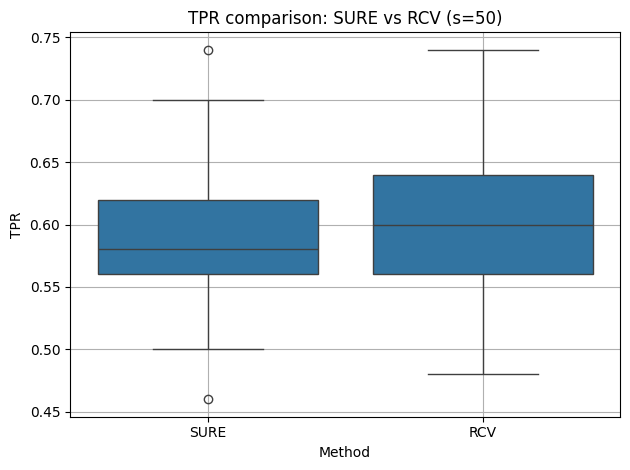

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import Lasso, LassoCV
from numpy.linalg import norm

# 参数设定
np.random.seed(42)
n, p, s = 100, 150, 50
B = 25000  # 模拟次数
sigma2_true = 1
a = 10
lambda_grid = np.logspace(-2.5, -0.5, 10)

# 构造 exchangeable 协方差矩阵
def generate_X(n, p, a=10):
    I = np.eye(p)
    E = np.ones((p, p))
    Gamma = I + a * E
    L = np.linalg.cholesky(Gamma)
    Z = np.random.randn(n, p)
    return Z @ L.T

# 构造 beta
def generate_beta(s, p=150):
    return np.concatenate([np.linspace(1, 0.1, 20), np.random.uniform(0, 0.1, 30), np.zeros(p - 50)])

# 计算 TPR
def compute_tpr(beta_true, beta_hat):
    true_support = set(np.where(beta_true != 0)[0])
    selected_support = set(np.where(beta_hat != 0)[0])
    tp = len(true_support & selected_support)
    fn = len(true_support - selected_support)
    return tp / (tp + fn) if (tp + fn) > 0 else np.nan

# SURE 方法选择 λ
def select_lambda_sure(X, y, lambda_grid, sigma2_true):
    best_sure, best_lambda = np.inf, None
    for lam in lambda_grid:
        model = Lasso(alpha=lam, fit_intercept=False, max_iter=10000).fit(X, y)
        beta = model.coef_
        df = np.sum(beta != 0)
        res = y - X @ beta
        sure = np.mean(res**2) + 2 * sigma2_true * df / n
        if sure < best_sure:
            best_sure = sure
            best_lambda = lam
    return best_lambda

# RCV 方法选择 λ
def select_lambda_rcv(X, y, lambda_grid):
    model = LassoCV(alphas=lambda_grid, cv=5, fit_intercept=False, max_iter=10000).fit(X, y)
    return model.alpha_

# 主循环：生成数据 + 拟合模型 + 记录 TPR
tpr_sure, tpr_rcv = [], []
beta_true = generate_beta(s, p)

for b in range(B):
    X = generate_X(n, p)
    eps = np.random.normal(0, np.sqrt(sigma2_true), size=n)
    y = X @ beta_true + eps

    lam_sure = select_lambda_sure(X, y, lambda_grid, sigma2_true)
    beta_sure = Lasso(alpha=lam_sure, fit_intercept=False, max_iter=10000).fit(X, y).coef_
    tpr_sure.append(compute_tpr(beta_true, beta_sure))

    lam_rcv = select_lambda_rcv(X, y, lambda_grid)
    beta_rcv = Lasso(alpha=lam_rcv, fit_intercept=False, max_iter=10000).fit(X, y).coef_
    tpr_rcv.append(compute_tpr(beta_true, beta_rcv))

# 整理数据并画图
df_tpr = pd.DataFrame({
    'TPR': tpr_sure + tpr_rcv,
    'Method': ['SURE'] * B + ['RCV'] * B
})

sns.boxplot(x='Method', y='TPR', data=df_tpr)
plt.title(f'TPR comparison: SURE vs RCV (s={s})')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
avg_lambda_rcv = np.mean([select_lambda_rcv(generate_X(n, p),
                                            generate_X(n, p) @ generate_beta(s, p) +
                                            np.random.normal(0, np.sqrt(sigma2_true), n),
                                            lambda_grid) for _ in range(50)])

avg_lambda_sure = np.mean([select_lambda_sure(generate_X(n, p),
                                               generate_X(n, p) @ generate_beta(s, p) +
                                               np.random.normal(0, np.sqrt(sigma2_true), n),
                                               lambda_grid, sigma2_true) for _ in range(50)])

print(f"Average λ (RCV): {avg_lambda_rcv:.4f}")
print(f"Average λ (SURE): {avg_lambda_sure:.4f}")


Average λ (RCV): 0.3137
Average λ (SURE): 0.0162


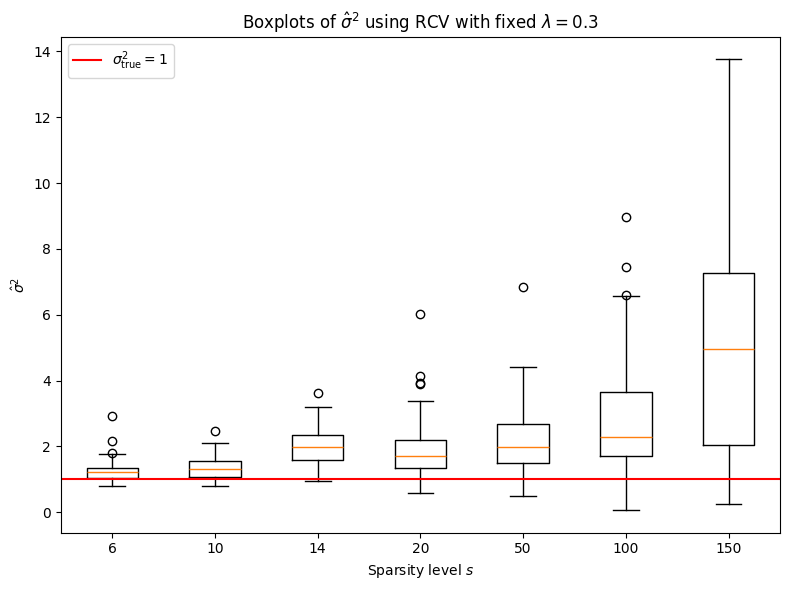

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from numpy.linalg import inv

# 参数设定
n = 100
p = 150
B = 25000
sigma2_true = 1
s_list = [6, 10, 14, 20, 50, 100, 150]
lambda_fixed = 0.3  # 固定 λ

# 构造 exchangeable 协方差结构的设计矩阵
def generate_X(n, p, a=10):
    I = np.eye(p)
    E = np.ones((p, p))
    Gamma = I + a * E
    L = np.linalg.cholesky(Gamma)
    Z = np.random.randn(n, p)
    return Z @ L.T

# 构造不同 sparsity 水平下的 beta 向量
def generate_beta(s, p=150):
    if s == 6:
        beta = np.array([1, -1, 0.5, -0.5, 0.2, 0] + [0]*(p-6))
    elif s == 10:
        beta = np.array([1, -1, 0.8, -0.6, 0.6, -0.4, 0.2, 0] + [0]*(p-8))
    elif s == 14:
        beta = np.array([1, -1, 0.8, -0.7, 0.7, -0.6, 0.6, -0.5, 0.5, -0.4, 0.4, -0.2, 0, 0] + [0]*(p-14))
    elif s == 20:
        beta = np.concatenate([np.linspace(1, 0.1, 20), np.zeros(p - 20)])
    elif s == 50:
        beta = np.concatenate([np.linspace(1, 0.1, 20), np.random.uniform(0, 0.1, 30), np.zeros(p - 50)])
    elif s == 100:
        beta = np.concatenate([np.linspace(1, 0.1, 20), np.random.uniform(0, 0.1, 80), np.zeros(p - 100)])
    elif s == 150:
        beta = np.concatenate([np.linspace(1, 0.1, 20), np.random.uniform(0, 0.1, 130)])
    return beta

def estimate_sigma2_rcv(X, y, lam):
    n = X.shape[0]
    half = n // 2
    X1, X2 = X[:half], X[half:]
    y1, y2 = y[:half], y[half:]

    # 第一折
    lasso1 = Lasso(alpha=lam, fit_intercept=False, max_iter=10000).fit(X1, y1)
    idx1 = np.where(lasso1.coef_ != 0)[0]
    if len(idx1) == 0 or len(idx1) >= half:
        return np.nan
    X2_sel = X2[:, idx1]
    P1 = X2_sel @ inv(X2_sel.T @ X2_sel) @ X2_sel.T
    sigma2_1 = (y2.T @ (np.eye(half) - P1) @ y2) / (half - len(idx1))

    # 第二折
    lasso2 = Lasso(alpha=lam, fit_intercept=False, max_iter=10000).fit(X2, y2)
    idx2 = np.where(lasso2.coef_ != 0)[0]
    if len(idx2) == 0 or len(idx2) >= half:
        return np.nan
    X1_sel = X1[:, idx2]
    P2 = X1_sel @ inv(X1_sel.T @ X1_sel) @ X1_sel.T
    sigma2_2 = (y1.T @ (np.eye(half) - P2) @ y1) / (half - len(idx2))

    # 加权平均
    num1, num2 = (half - len(idx1)), (half - len(idx2))
    denom = num1 + num2
    if denom == 0:
        return np.nan
    sigma2_rcv = sigma2_1 * (num1 / denom) + sigma2_2 * (num2 / denom)
    return sigma2_rcv


# 模拟
results = {s: [] for s in s_list}
for s in s_list:
    beta = generate_beta(s, p)
    for _ in range(B):
        X = generate_X(n, p)
        eps = np.random.normal(0, np.sqrt(sigma2_true), size=n)
        y = X @ beta + eps
        sigma2_hat = estimate_sigma2_rcv(X, y, lambda_fixed)
        if not np.isnan(sigma2_hat):
            results[s].append(sigma2_hat)

# 绘图
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([results[s] for s in s_list], labels=s_list)
ax.axhline(y=sigma2_true, color='r', linestyle='-', label=r'$\sigma^2_{\text{true}} = 1$')
ax.set_xlabel("Sparsity level $s$")
ax.set_ylabel(r"$\hat{\sigma}^2$")
ax.set_title(r"Boxplots of $\hat{\sigma}^2$ using RCV with fixed $\lambda = 0.3$")
ax.legend()
plt.tight_layout()
plt.show()


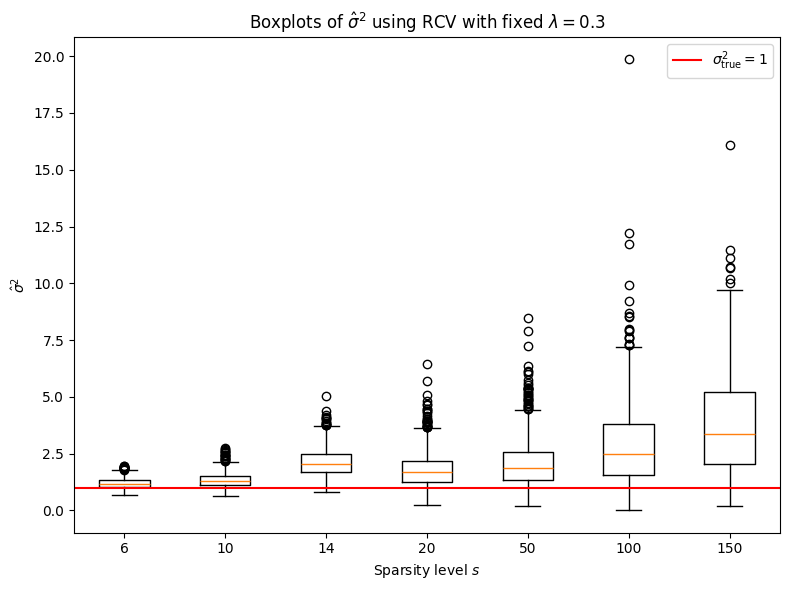

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from numpy.linalg import inv

# 参数设定
n = 100
p = 150
B = 25000
sigma2_true = 1
s_list = [6, 10, 14, 20, 50, 100, 150]
lambda_fixed = 0.3  # 固定 λ

# 构造 exchangeable 协方差结构的设计矩阵
def generate_X(n, p, a=10):
    I = np.eye(p)
    E = np.ones((p, p))
    Gamma = I + a * E
    L = np.linalg.cholesky(Gamma)
    Z = np.random.randn(n, p)
    return Z @ L.T

# 构造不同 sparsity 水平下的 beta 向量
def generate_beta(s, p=150):
    if s == 6:
        beta = np.array([1, -1, 0.5, -0.5, 0.2, 0] + [0]*(p-6))
    elif s == 10:
        beta = np.array([1, -1, 0.8, -0.6, 0.6, -0.4, 0.2, 0] + [0]*(p-8))
    elif s == 14:
        beta = np.array([1, -1, 0.8, -0.7, 0.7, -0.6, 0.6, -0.5, 0.5, -0.4, 0.4, -0.2, 0, 0] + [0]*(p-14))
    elif s == 20:
        beta = np.concatenate([np.linspace(1, 0.1, 20), np.zeros(p - 20)])
    elif s == 50:
        beta = np.concatenate([np.linspace(1, 0.1, 20), np.random.uniform(0, 0.1, 30), np.zeros(p - 50)])
    elif s == 100:
        beta = np.concatenate([np.linspace(1, 0.1, 20), np.random.uniform(0, 0.1, 80), np.zeros(p - 100)])
    elif s == 150:
        beta = np.concatenate([np.linspace(1, 0.1, 20), np.random.uniform(0, 0.1, 130)])
    return beta

def estimate_sigma2_rcv(X, y, lam):
    n = X.shape[0]
    half = n // 2
    X1, X2 = X[:half], X[half:]
    y1, y2 = y[:half], y[half:]

    # 第一折
    lasso1 = Lasso(alpha=lam, fit_intercept=False, max_iter=10000).fit(X1, y1)
    idx1 = np.where(lasso1.coef_ != 0)[0]
    if len(idx1) == 0 or len(idx1) >= half:
        return np.nan
    X2_sel = X2[:, idx1]
    P1 = X2_sel @ inv(X2_sel.T @ X2_sel) @ X2_sel.T
    sigma2_1 = (y2.T @ (np.eye(half) - P1) @ y2) / (half - len(idx1))

    # 第二折
    lasso2 = Lasso(alpha=lam, fit_intercept=False, max_iter=10000).fit(X2, y2)
    idx2 = np.where(lasso2.coef_ != 0)[0]
    if len(idx2) == 0 or len(idx2) >= half:
        return np.nan
    X1_sel = X1[:, idx2]
    P2 = X1_sel @ inv(X1_sel.T @ X1_sel) @ X1_sel.T
    sigma2_2 = (y1.T @ (np.eye(half) - P2) @ y1) / (half - len(idx2))

    # 加权平均
    num1, num2 = (half - len(idx1)), (half - len(idx2))
    denom = num1 + num2
    if denom == 0:
        return np.nan
    sigma2_rcv = sigma2_1 * (num1 / denom) + sigma2_2 * (num2 / denom)
    return sigma2_rcv


# 模拟
results = {s: [] for s in s_list}
for s in s_list:
    beta = generate_beta(s, p)
    for _ in range(B):
        X = generate_X(n, p)
        eps = np.random.normal(0, np.sqrt(sigma2_true), size=n)
        y = X @ beta + eps
        sigma2_hat = estimate_sigma2_rcv(X, y, lambda_fixed)
        if not np.isnan(sigma2_hat):
            results[s].append(sigma2_hat)

# 绘图
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([results[s] for s in s_list], labels=s_list)
ax.axhline(y=sigma2_true, color='r', linestyle='-', label=r'$\sigma^2_{\text{true}} = 1$')
ax.set_xlabel("Sparsity level $s$")
ax.set_ylabel(r"$\hat{\sigma}^2$")
ax.set_title(r"Boxplots of $\hat{\sigma}^2$ using RCV with fixed $\lambda = 0.3$")
ax.legend()
plt.tight_layout()
plt.show()

<ipython-input-17-828ccfe5dd89>:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([results_corrected[s] for s in s_list], labels=s_list)


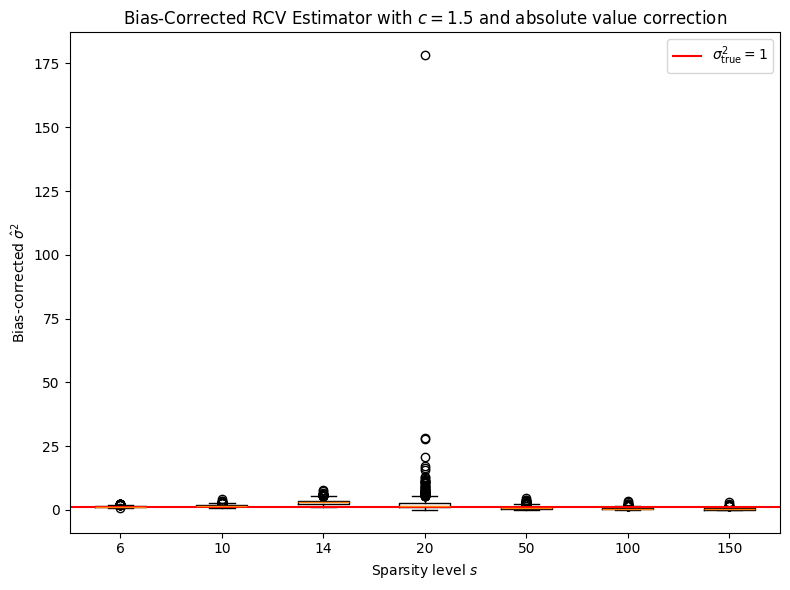

In [ ]:
# Bias-corrected sigma2 values (with abs instead of lower bound)
results_corrected = {}
c = 1.5  # 惩罚因子，控制 bias correction 程度

for s in s_list:
    corrected_values = []
    for _ in range(B):
        X = generate_X(n, p)
        beta = generate_beta(s, p)
        eps = np.random.normal(0, np.sqrt(sigma2_true), size=n)
        y = X @ beta + eps

        n_half = n // 2
        X1, X2 = X[:n_half], X[n_half:]
        y1, y2 = y[:n_half], y[n_half:]

        lasso1 = Lasso(alpha=lambda_fixed, fit_intercept=False, max_iter=10000).fit(X1, y1)
        M1 = np.where(lasso1.coef_ != 0)[0]
        if len(M1) == 0 or len(M1) >= n_half:
            continue
        X2_M1 = X2[:, M1]
        P1 = X2_M1 @ np.linalg.inv(X2_M1.T @ X2_M1) @ X2_M1.T
        rss1 = y2.T @ (np.eye(n_half) - P1) @ y2
        sigma2_1 = rss1 / (n_half - c * len(M1))

        lasso2 = Lasso(alpha=lambda_fixed, fit_intercept=False, max_iter=10000).fit(X2, y2)
        M2 = np.where(lasso2.coef_ != 0)[0]
        if len(M2) == 0 or len(M2) >= n_half:
            continue
        X1_M2 = X1[:, M2]
        P2 = X1_M2 @ np.linalg.inv(X1_M2.T @ X1_M2) @ X1_M2.T
        rss2 = y1.T @ (np.eye(n_half) - P2) @ y1
        sigma2_2 = rss2 / (n_half - c * len(M2))

        num1 = n_half - c * len(M1)
        num2 = n_half - c * len(M2)
        denom = num1 + num2
        sigma2_corr = abs((sigma2_1 * num1 + sigma2_2 * num2) / denom)  # 取绝对值防止负数

        corrected_values.append(sigma2_corr)

    results_corrected[s] = corrected_values

# 绘图
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([results_corrected[s] for s in s_list], labels=s_list)
ax.axhline(y=sigma2_true, color='r', linestyle='-', label=r'$\sigma^2_{\text{true}} = 1$')
ax.set_xlabel("Sparsity level $s$")
ax.set_ylabel(r"Bias-corrected $\hat{\sigma}^2$")
ax.set_title(r"Bias-Corrected RCV Estimator with $c = 1.5$ and absolute value correction")
ax.legend()
plt.tight_layout()
plt.show()


<ipython-input-19-9cdccb2119b0>:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([results_corrected[s] for s in s_list], labels=s_list)


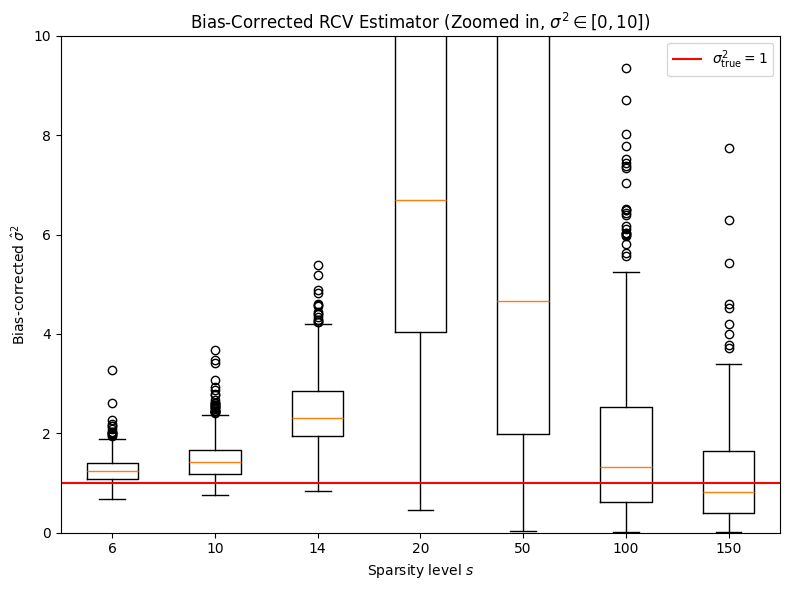

In [ ]:
# Bias-corrected sigma2 values (with abs instead of lower bound)
results_corrected = {}
c = 1.2  # 惩罚因子，控制 bias correction 程度

for s in s_list:
    corrected_values = []
    for _ in range(B):
        X = generate_X(n, p)
        beta = generate_beta(s, p)
        eps = np.random.normal(0, np.sqrt(sigma2_true), size=n)
        y = X @ beta + eps

        n_half = n // 2
        X1, X2 = X[:n_half], X[n_half:]
        y1, y2 = y[:n_half], y[n_half:]

        lasso1 = Lasso(alpha=lambda_fixed, fit_intercept=False, max_iter=10000).fit(X1, y1)
        M1 = np.where(lasso1.coef_ != 0)[0]
        if len(M1) == 0 or len(M1) >= n_half:
            continue
        X2_M1 = X2[:, M1]
        P1 = X2_M1 @ np.linalg.inv(X2_M1.T @ X2_M1) @ X2_M1.T
        rss1 = y2.T @ (np.eye(n_half) - P1) @ y2
        sigma2_1 = rss1 / (n_half - c * len(M1))

        lasso2 = Lasso(alpha=lambda_fixed, fit_intercept=False, max_iter=10000).fit(X2, y2)
        M2 = np.where(lasso2.coef_ != 0)[0]
        if len(M2) == 0 or len(M2) >= n_half:
            continue
        X1_M2 = X1[:, M2]
        P2 = X1_M2 @ np.linalg.inv(X1_M2.T @ X1_M2) @ X1_M2.T
        rss2 = y1.T @ (np.eye(n_half) - P2) @ y1
        sigma2_2 = rss2 / (n_half - c * len(M2))

        num1 = n_half - c * len(M1)
        num2 = n_half - c * len(M2)
        denom = num1 + num2
        sigma2_corr = abs((sigma2_1 * num1 + sigma2_2 * num2) / denom)  # 取绝对值防止负数

        corrected_values.append(sigma2_corr)

    results_corrected[s] = corrected_values

# 只重新画图：压缩 y 轴范围为 (0, 10)，更清晰展示主体部分
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([results_corrected[s] for s in s_list], labels=s_list)
ax.axhline(y=sigma2_true, color='r', linestyle='-', label=r'$\sigma^2_{\text{true}} = 1$')
ax.set_xlabel("Sparsity level $s$")
ax.set_ylabel(r"Bias-corrected $\hat{\sigma}^2$")
ax.set_title(r"Bias-Corrected RCV Estimator (Zoomed in, $\sigma^2 \in [0, 10]$)")
ax.set_ylim(0, 10)  # 设置 y 轴范围压缩显示
ax.legend()
plt.tight_layout()
plt.show()

<ipython-input-20-735d22c550f2>:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([results_corrected[s] for s in s_list], labels=s_list)


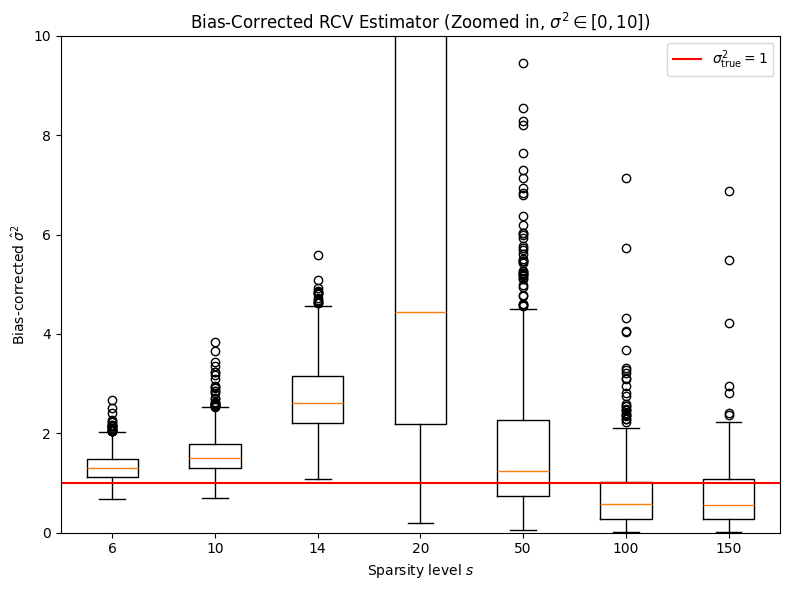

In [ ]:
# Bias-corrected sigma2 values (with abs instead of lower bound)
results_corrected = {}
c = 1.35  # 惩罚因子，控制 bias correction 程度

for s in s_list:
    corrected_values = []
    for _ in range(B):
        X = generate_X(n, p)
        beta = generate_beta(s, p)
        eps = np.random.normal(0, np.sqrt(sigma2_true), size=n)
        y = X @ beta + eps

        n_half = n // 2
        X1, X2 = X[:n_half], X[n_half:]
        y1, y2 = y[:n_half], y[n_half:]

        lasso1 = Lasso(alpha=lambda_fixed, fit_intercept=False, max_iter=10000).fit(X1, y1)
        M1 = np.where(lasso1.coef_ != 0)[0]
        if len(M1) == 0 or len(M1) >= n_half:
            continue
        X2_M1 = X2[:, M1]
        P1 = X2_M1 @ np.linalg.inv(X2_M1.T @ X2_M1) @ X2_M1.T
        rss1 = y2.T @ (np.eye(n_half) - P1) @ y2
        sigma2_1 = rss1 / (n_half - c * len(M1))

        lasso2 = Lasso(alpha=lambda_fixed, fit_intercept=False, max_iter=10000).fit(X2, y2)
        M2 = np.where(lasso2.coef_ != 0)[0]
        if len(M2) == 0 or len(M2) >= n_half:
            continue
        X1_M2 = X1[:, M2]
        P2 = X1_M2 @ np.linalg.inv(X1_M2.T @ X1_M2) @ X1_M2.T
        rss2 = y1.T @ (np.eye(n_half) - P2) @ y1
        sigma2_2 = rss2 / (n_half - c * len(M2))

        num1 = n_half - c * len(M1)
        num2 = n_half - c * len(M2)
        denom = num1 + num2
        sigma2_corr = abs((sigma2_1 * num1 + sigma2_2 * num2) / denom)  # 取绝对值防止负数

        corrected_values.append(sigma2_corr)

    results_corrected[s] = corrected_values

# 只重新画图：压缩 y 轴范围为 (0, 10)，更清晰展示主体部分
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([results_corrected[s] for s in s_list], labels=s_list)
ax.axhline(y=sigma2_true, color='r', linestyle='-', label=r'$\sigma^2_{\text{true}} = 1$')
ax.set_xlabel("Sparsity level $s$")
ax.set_ylabel(r"Bias-corrected $\hat{\sigma}^2$")
ax.set_title(r"Bias-Corrected RCV Estimator (Zoomed in, $\sigma^2 \in [0, 10]$)")
ax.set_ylim(0, 10)  # 设置 y 轴范围压缩显示
ax.legend()
plt.tight_layout()
plt.show()

<ipython-input-21-a98fd20f36d8>:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([results_corrected[s] for s in plot_s_list], labels=plot_s_list)


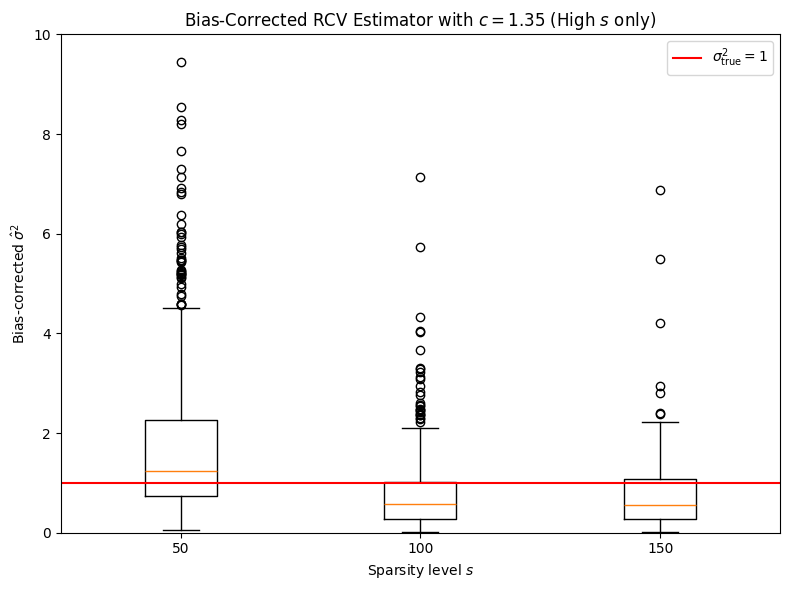

In [ ]:
# 只绘制 s = 50, 100, 150 的 boxplot，y 轴压缩至 [0, 10]
plot_s_list = [50, 100, 150]

fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([results_corrected[s] for s in plot_s_list], labels=plot_s_list)
ax.axhline(y=sigma2_true, color='r', linestyle='-', label=r'$\sigma^2_{\text{true}} = 1$')
ax.set_xlabel("Sparsity level $s$")
ax.set_ylabel(r"Bias-corrected $\hat{\sigma}^2$")
ax.set_title(r"Bias-Corrected RCV Estimator with $c = 1.35$ (High $s$ only)")
ax.set_ylim(0, 10)
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from numpy.linalg import pinv
from tqdm import tqdm

# 参数设定
n = 100
p = 150
B = 25000
sigma2_true = 1
lambda_fixed = 0.3
gamma = np.sqrt((1 - 0.5) / 0.5)
s_list = [6, 20, 50, 100, 150]
beta_values = [0.0, 0.2, 0.5, 1.0]

# 构造设计矩阵
def generate_X(n, p, a=10):
    I = np.eye(p)
    E = np.ones((p, p))
    Gamma = I + a * E
    L = np.linalg.cholesky(Gamma)
    return np.random.randn(n, p) @ L.T

# 构造 beta
def generate_beta(s, p=150):
    if s == 6:
        return np.array([1, -1, 0.5, -0.5, 0.2, 0] + [0]*(p-6))
    elif s == 20:
        return np.concatenate([np.linspace(1, 0.1, 20), np.zeros(p - 20)])
    elif s == 50:
        return np.concatenate([np.linspace(1, 0.1, 20), np.random.uniform(0, 0.1, 30), np.zeros(p - 50)])
    elif s == 100:
        return np.concatenate([np.linspace(1, 0.1, 20), np.random.uniform(0, 0.1, 80), np.zeros(p - 100)])
    elif s == 150:
        return np.concatenate([np.linspace(1, 0.1, 20), np.random.uniform(0, 0.1, 130)])

# sigma² RCV估计
def estimate_sigma2_rcv(X, y, lam):
    half = n // 2
    X1, X2 = X[:half], X[half:]
    y1, y2 = y[:half], y[half:]

    lasso1 = Lasso(alpha=lam, fit_intercept=False, max_iter=10000).fit(X1, y1)
    idx1 = np.where(lasso1.coef_ != 0)[0]
    if len(idx1) == 0 or len(idx1) >= half: return np.nan
    X2_sel = X2[:, idx1]
    P1 = X2_sel @ pinv(X2_sel.T @ X2_sel) @ X2_sel.T
    sigma2_1 = y2.T @ (np.eye(half) - P1) @ y2 / (half - len(idx1))

    lasso2 = Lasso(alpha=lam, fit_intercept=False, max_iter=10000).fit(X2, y2)
    idx2 = np.where(lasso2.coef_ != 0)[0]
    if len(idx2) == 0 or len(idx2) >= half: return np.nan
    X1_sel = X1[:, idx2]
    P2 = X1_sel @ pinv(X1_sel.T @ X1_sel) @ X1_sel.T
    sigma2_2 = y1.T @ (np.eye(half) - P2) @ y1 / (half - len(idx2))

    num1, num2 = half - len(idx1), half - len(idx2)
    return (sigma2_1 * num1 + sigma2_2 * num2) / (num1 + num2)

# 主程序
records = []
for s in s_list:
    beta = generate_beta(s, p)
    for b_val in beta_values:
        true_lengths, est_lengths = [], []
        for _ in tqdm(range(B), desc=f"s={s}, |β|={b_val}"):
            X = generate_X(n, p)
            eps = np.random.normal(0, np.sqrt(sigma2_true), size=n)
            y = X @ beta + eps

            W = np.random.normal(0, np.sqrt(sigma2_true), size=n)
            U = y + gamma * W
            V = y - W / gamma

            model = Lasso(alpha=lambda_fixed / 2, fit_intercept=False, max_iter=10000).fit(X, U)
            selected = np.where(model.coef_ != 0)[0]
            if len(selected) == 0 or len(selected) >= n: continue

            X_sel = X[:, selected]
            beta_hat = pinv(X_sel.T @ X_sel) @ X_sel.T @ V
            XtX_inv_diag = np.diag(pinv(X_sel.T @ X_sel))

            sigma2_est = estimate_sigma2_rcv(X, y, lambda_fixed)
            if np.isnan(sigma2_est): continue

            se_true = np.sqrt(sigma2_true * (1 + gamma**-2) * XtX_inv_diag)
            se_est = np.sqrt(sigma2_est * (1 + gamma**-2) * XtX_inv_diag)

            for i, j in enumerate(selected):
                if round(abs(beta[j]), 1) == b_val:
                    true_lengths.append(2 * 1.96 * se_true[i])
                    est_lengths.append(2 * 1.96 * se_est[i])

        if len(true_lengths) > 0:
            records.append({
                '|βᵢ|': b_val,
                's': s,
                'σ²_true_median': np.median(true_lengths),
                'σ²_true_sd': np.std(true_lengths),
                'σ²_est_median': np.median(est_lengths),
                'σ²_est_sd': np.std(est_lengths)
            })

df_uv = pd.DataFrame(records)
print(df_uv)


s=6, |β|=0.0: 100%|██████████| 500/500 [00:17<00:00, 28.25it/s]
s=6, |β|=0.2: 100%|██████████| 500/500 [00:17<00:00, 29.35it/s]
s=6, |β|=0.5: 100%|██████████| 500/500 [00:16<00:00, 29.74it/s]
s=6, |β|=1.0: 100%|██████████| 500/500 [00:17<00:00, 28.17it/s]
s=20, |β|=0.0: 100%|██████████| 500/500 [00:53<00:00,  9.43it/s]
s=20, |β|=0.2: 100%|██████████| 500/500 [00:53<00:00,  9.42it/s]
s=20, |β|=0.5: 100%|██████████| 500/500 [00:53<00:00,  9.30it/s]
s=20, |β|=1.0: 100%|██████████| 500/500 [00:53<00:00,  9.34it/s]
s=50, |β|=0.0: 100%|██████████| 500/500 [01:04<00:00,  7.73it/s]
s=50, |β|=0.2: 100%|██████████| 500/500 [01:05<00:00,  7.66it/s]
s=50, |β|=0.5: 100%|██████████| 500/500 [01:05<00:00,  7.62it/s]
s=50, |β|=1.0: 100%|██████████| 500/500 [01:06<00:00,  7.55it/s]
s=100, |β|=0.0: 100%|██████████| 500/500 [01:16<00:00,  6.51it/s]
s=100, |β|=0.2: 100%|██████████| 500/500 [01:17<00:00,  6.42it/s]
s=100, |β|=0.5: 100%|██████████| 500/500 [01:19<00:00,  6.31it/s]
s=100, |β|=1.0: 100%|█████

    |βᵢ|    s  σ²_true_median  σ²_true_sd  σ²_est_median  σ²_est_sd
0    0.0    6        0.647334    0.058789       0.699997   0.099624
1    0.2    6        0.641186    0.054074       0.696634   0.092673
2    0.5    6        0.656502    0.063459       0.704254   0.106008
3    1.0    6        0.652922    0.060648       0.705494   0.103307
4    0.0   20        0.747968    0.080808       0.963015   0.237944
5    0.2   20        0.755110    0.079422       0.974196   0.245077
6    0.5   20        0.746535    0.077376       0.966796   0.229475
7    1.0   20        0.753002    0.084682       0.962436   0.235497
8    0.0   50        0.791118    0.089995       1.075240   0.334387
9    0.2   50        0.789945    0.083652       1.087297   0.331461
10   0.5   50        0.793246    0.095580       1.095133   0.346676
11   1.0   50        0.793159    0.089286       1.075593   0.304065
12   0.0  100        0.872551    0.112595       1.366346   0.559921
13   0.2  100        0.865793    0.106367       